In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
PATH = '../content/gdrive/MyDrive/DS_final_proj/'

In [ ]:
!ls /content/gdrive/MyDrive/DS_final_proj/

holidays_events.csv  sample_submission.csv  test.csv   transactions.csv
oil.csv		     stores.csv		    train.csv


In [ ]:
train = pd.read_csv(PATH + 'train.csv', dtype={'store_nbr': 'category'}, 
                    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'])
test = pd.read_csv(PATH + 'test.csv', dtype={'store_nbr': 'category'},
                   usecols=['store_nbr', 'family', 'date', 'onpromotion'])

# Проверка пропущенных значений
print('Пропущенные значения в обучающей выборке:', train.isna().sum().sum())
print('Пропущенные значения в тестовой выборке:', test.isna().sum().sum())

# В тренировочном наборе отсутствуют некоторые даты ['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'] 

train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

Пропущенные значения в обучающей выборке: 0
Пропущенные значения в тестовой выборке: 0


In [ ]:
train.head(10)

,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0
5,2013-01-01,1,BREAD/BAKERY,0.0,0
6,2013-01-01,1,CELEBRATION,0.0,0
7,2013-01-01,1,CLEANING,0.0,0
8,2013-01-01,1,DAIRY,0.0,0
9,2013-01-01,1,DELI,0.0,0


In [ ]:
test.head(5)

,date,store_nbr,family,onpromotion
0,2017-08-16,1,AUTOMOTIVE,0
1,2017-08-16,1,BABY CARE,0
2,2017-08-16,1,BEAUTY,2
3,2017-08-16,1,BEVERAGES,20
4,2017-08-16,1,BOOKS,0


# **1. ПРЕДАНАЛИЗ**

# 1.1. Продажи магазинов

In [ ]:
temp = train.set_index('date').groupby('store_nbr').resample('D').sales.sum().reset_index()
px.line(temp, x='date', y='sales', color='store_nbr',
        title='Ежедневный общий объем продаж магазинов')

In [ ]:
print(train.shape)
train = train[~((train.store_nbr == '52') & (train.date < "2017-04-20"))]
train = train[~((train.store_nbr == '22') & (train.date < "2015-10-09"))]
train = train[~((train.store_nbr == '42') & (train.date < "2015-08-21"))]
train = train[~((train.store_nbr == '21') & (train.date < "2015-07-24"))]
train = train[~((train.store_nbr == '29') & (train.date < "2015-03-20"))]
train = train[~((train.store_nbr == '20') & (train.date < "2015-02-13"))]
train = train[~((train.store_nbr == '53') & (train.date < "2014-05-29"))]
train = train[~((train.store_nbr == '36') & (train.date < "2013-05-09"))]
print(train.shape)

(3000888, 5)
(2780316, 5)


In [ ]:
train.corr('spearman').sales.loc['onpromotion']

0.5328877286580788

In [ ]:
transactions = pd.read_csv(PATH + 'transactions.csv', dtype={'store_nbr': 'category'})
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [ ]:
print('Пропущенные значения в транзакциях:', train.isna().sum().sum())

# Пропущенные значения ['2013-12-25', '2014-12-25', '2015-12-25', 
#                                                 '2016-01-01', '2016-01-03', '2016-12-25']

transactions['date'] = pd.to_datetime(transactions['date'])

# Доказательство того, что транзакции тесно связаны с продажами
temp = pd.merge(train.groupby(['date', 'store_nbr']).sales.sum().reset_index(),
                transactions, how='left')
print(temp.corr("spearman").sales.loc["transactions"])

# Теперь мы можем доказать, что магазины в праздничные дни зарабатывают больше, чем в рабочие дни
temp = transactions.copy()
temp['year'] = temp.date.dt.year
temp['day_of_week'] = temp.date.dt.dayofweek + 1
temp = temp.groupby(['year', 'day_of_week']).transactions.mean().reset_index()

px.line(temp, x='day_of_week', y='transactions', color='year', title='Транзакции')

Пропущенные значения в транзакциях: 0
0.8174644353073427


# 1.2. Праздники

In [ ]:
def strip_spaces(a_str_with_spaces):
    return a_str_with_spaces.replace(' ', '')

holidays = pd.read_csv(PATH + 'holidays_events.csv', index_col='date',
                       parse_dates=['date'], infer_datetime_format=True,
                       converters={'locale_name': strip_spaces})  # убираем пропуски

holidays.head()

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [ ]:
# Уникальные значения, проверув данные на наличие орфографических ошибок и лучшее понимание данные
print('Holidays types:', holidays['type'].unique())
print('Holidays region types:', holidays['locale'].unique()) 
print('Holidays locale names:', holidays['locale_name'].unique())  

Holidays types: ['Holiday' 'Transfer' 'Additional' 'Bridge' 'Work Day' 'Event']
Holidays region types: ['Local' 'Regional' 'National']
Holidays locale names: ['Manta' 'Cotopaxi' 'Cuenca' 'Libertad' 'Riobamba' 'Puyo' 'Guaranda'
 'Imbabura' 'Latacunga' 'Machala' 'SantoDomingo' 'ElCarmen' 'Cayambe'
 'Esmeraldas' 'Ecuador' 'Ambato' 'Ibarra' 'Quevedo'
 'SantoDomingodelosTsachilas' 'SantaElena' 'Quito' 'Loja' 'Salinas'
 'Guayaquil']


In [ ]:
# Пропущенные значения
holidays.isna().sum()  


type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [ ]:
# Календарь
holidays_rdy = pd.DataFrame(index=pd.date_range('2013-01-01', '2017-08-31'))
holidays_rdy['day_of_week'] = holidays_rdy.index.dayofweek + 1  # Понедельник = 1, Воскресенье = 7
holidays_rdy['work_day'] = True
holidays_rdy.loc[holidays_rdy['day_of_week'] > 5, 'work_day'] = False  # False для выходных 

# Исправление дубликатов индексов в наборе данных о праздниках
duplicates = holidays[holidays.index.duplicated(keep=False)]
print(duplicates['locale_name'])
duplicates = [('2012-06-25', 'Latacunga Machala'), ('2012-07-03', 'ElCarmen'),
              ('2012-12-22', 'Ecuador'), ('2012-12-24', 'Ecuador'),
              ('2012-12-31', 'Ecuador'), ('2013-05-12', 'Ecuador'),
              ('2013-06-25', 'Machala Latacunga'), ('2013-07-03', 'SantoDomingo'),
              ('2013-12-22', 'Salinas'), ('2014-06-25', 'Machala Imbabura Ecuador'),
              ('2014-07-03', 'SantoDomingo'), ('2014-12-22', 'Ecuador'),
              ('2014-12-26', 'Ecuador'), ('2015-06-25', 'Imbabura Latacunga'),
              ('2015-07-03', 'SantoDomingo'), ('2015-12-22', 'Salinas'),
              ('2016-04-21', 'Ecuador'), ('2016-05-01', 'Ecuador'),
              ('2016-05-07', 'Ecuador'), ('2016-05-08', 'Ecuador'),
              ('2016-05-12', 'Ecuador'), ('2016-06-25', 'Imbabura Latacunga'),
              ('2016-07-03', 'SantoDomingo'), ('2016-07-24', 'Guayaquil'),
              ('2016-11-12', 'Ecuador'), ('2016-12-22', 'Salinas'),
              ('2017-04-14', 'Ecuador'), ('2017-06-25', 'Latacunga Machala'),
              ('2017-07-03', 'SantoDomingo'), ('2017-12-08', 'Quito'),
              ('2017-12-22', 'Ecuador')]

# Ни один праздник не был перенесен в двух экземплярах.

holidays = holidays.groupby(holidays.index).first() 
for date, locale_name in duplicates:
    holidays.loc[date, 'locale_name'] = holidays.loc[date, 'locale_name'] + ' ' + locale_name

date
2012-06-25        Imbabura
2012-06-25       Latacunga
2012-06-25         Machala
2012-07-03    SantoDomingo
2012-07-03        ElCarmen
                  ...     
2017-07-03    SantoDomingo
2017-12-08            Loja
2017-12-08           Quito
2017-12-22         Salinas
2017-12-22         Ecuador
Name: locale_name, Length: 69, dtype: object


In [ ]:
holidays_rdy = holidays_rdy.merge(holidays, how='left', left_index=True, right_index=True)

holidays_rdy.loc[holidays_rdy['type'] == 'Work Day', 'work_day'] = True

holidays_rdy.loc[(holidays_rdy['type'] == 'Holiday') &
                 (holidays_rdy['locale_name'].str.contains('Ecuador', na=False)),
                 'work_day'] = False
holidays_rdy.loc[(holidays_rdy['type'] == 'Transfer') & 
                 (holidays_rdy['locale_name'].str.contains('Ecuador', na=False)),  
                 'work_day'] = False
holidays_rdy.loc[(holidays_rdy['type'] == 'Additional') & 
                 (holidays_rdy['locale_name'].str.contains('Ecuador', na=False)),
                 'work_day'] = False
holidays_rdy.loc[(holidays_rdy['type'] == 'Bridge') & 
                 (holidays_rdy['locale_name'].str.contains('Ecuador', na=False)),   
                 'work_day'] = False

holidays_rdy.drop(['locale'], axis=1, inplace=True)

holidays_rdy.loc[holidays_rdy['transferred'] == True, 'work_day'] = True

In [ ]:
# Сначала посмотрим на события
events = holidays_rdy[holidays_rdy['type']=='Event']
events

,day_of_week,work_day,type,locale_name,description,transferred
2014-05-11,7,False,Event,Ecuador,Dia de la Madre,False
2014-06-12,4,True,Event,Ecuador,Inauguracion Mundial de futbol Brasil,False
2014-06-15,7,False,Event,Ecuador,Mundial de futbol Brasil: Ecuador-Suiza,False
2014-06-20,5,True,Event,Ecuador,Mundial de futbol Brasil: Ecuador-Honduras,False
2014-06-28,6,False,Event,Ecuador,Mundial de futbol Brasil: Octavos de Final,False
2014-06-29,7,False,Event,Ecuador,Mundial de futbol Brasil: Octavos de Final,False
2014-06-30,1,True,Event,Ecuador,Mundial de futbol Brasil: Octavos de Final,False
2014-07-01,2,True,Event,Ecuador,Mundial de futbol Brasil: Octavos de Final,False
2014-07-04,5,True,Event,Ecuador,Mundial de futbol Brasil: Cuartos de Final,False
2014-07-05,6,False,Event,Ecuador,Mundial de futbol Brasil: Cuartos de Final,False


In [ ]:
holidays_rdy.loc[holidays_rdy['description'].str.contains('Terremoto', na=False),
                 'description'] = 'Earthquake'
holidays_rdy.loc[holidays_rdy['description'].str.contains('futbol', na=False), 
                 'description'] = 'Football'
events = holidays_rdy[holidays_rdy['type']=='Event']

# Проверка на опечатки
print(events['description'].unique())

# Вывести среднее значение продаж 
sales = train.groupby(['date']).sales.sum()
events = events.merge(sales, how='left', left_index=True, right_index=True)
print(events.groupby(['description']).sales.mean())
print('All sales mean:', sales.mean())

['Dia de la Madre' 'Football' 'Black Friday' 'Cyber Monday' 'Earthquake']
description
Black Friday       647508.781658
Cyber Monday       777344.484674
Dia de la Madre    632258.371941
Earthquake         866433.436092
Football           569432.001918
Name: sales, dtype: float64
All sales mean: 637556.3849186873


In [ ]:
# описание 
descriptions = pd.get_dummies(holidays_rdy['description'])[['Earthquake', 'Cyber Monday', 'Black Friday']]
holidays_rdy = holidays_rdy.merge(descriptions, how='left', left_index=True, right_index=True)

# Заполнение NaNs
holidays_rdy['locale_name'].fillna('Ecuador', inplace=True)

# Избавление от бесполезных столбцов
holidays_rdy.drop(['type', 'description', 'transferred'], axis=1, inplace=True)

In [ ]:
holidays_rdy['date'] = holidays_rdy.index
holidays_rdy['date'] = pd.to_datetime(holidays_rdy['date'])
holidays_rdy['date'] = holidays_rdy['date'].dt.to_period('D')
holidays_rdy = holidays_rdy.set_index(['date'])

holidays_rdy = pd.get_dummies(holidays_rdy, columns=['day_of_week'])

holidays_rdy.head()

,work_day,locale_name,Earthquake,Cyber Monday,Black Friday,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,day_of_week_7
date,,,,,,,,,,,,
2013-01-01,False,Ecuador,0,0,0,0,1,0,0,0,0,0
2013-01-02,True,Ecuador,0,0,0,0,0,1,0,0,0,0
2013-01-03,True,Ecuador,0,0,0,0,0,0,1,0,0,0
2013-01-04,True,Ecuador,0,0,0,0,0,0,0,1,0,0
2013-01-05,True,Ecuador,0,0,0,0,0,0,0,0,1,0


# 1.3. Цены на нефть

In [ ]:
oil = pd.read_csv(PATH + 'oil.csv')
oil['date'] = pd.to_datetime(oil['date'])
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [ ]:
# ресамплинг
oil = oil.set_index('date')['dcoilwtico'].resample(
    'D').sum().reset_index()  # дополнение пропущенных дат и заполнение NaNs нулями 

# Интерполяция
oil['dcoilwtico'] = np.where(oil['dcoilwtico']==0, np.nan, oil['dcoilwtico'])  # заполнение 0 NaN
oil['dcoilwtico_interpolated'] = oil.dcoilwtico.interpolate()  # заполнение NaN значения используя интерполяцию

oil.head(10)

,date,dcoilwtico,dcoilwtico_interpolated
0,2013-01-01,NaN,NaN
1,2013-01-02,93.14,93.140000
2,2013-01-03,92.97,92.970000
3,2013-01-04,93.12,93.120000
4,2013-01-05,NaN,93.146667
5,2013-01-06,NaN,93.173333
6,2013-01-07,93.20,93.200000
7,2013-01-08,93.21,93.210000
8,2013-01-09,93.08,93.080000
9,2013-01-10,93.81,93.810000


In [ ]:
temp = oil.melt(id_vars=['date'], var_name='Legend') 
px.line(temp.sort_values(['Legend', 'date'], ascending=[False, True]), x='date',
        y='value', color='Legend', title='Дневные цены на нефть')

In [ ]:
oil_rdy = oil.loc[:, ['date', 'dcoilwtico_interpolated']]
oil_rdy.iloc[0, 1] = 93.1

assert oil_rdy.isna().sum().sum() == 0

oil_rdy['date'] = pd.to_datetime(oil_rdy['date'])
oil_rdy['date'] = oil_rdy['date'].dt.to_period('D')
oil_rdy = oil_rdy.set_index(['date'])
oil_rdy

,dcoilwtico_interpolated
date,
2013-01-01,93.100000
2013-01-02,93.140000
2013-01-03,92.970000
2013-01-04,93.120000
2013-01-05,93.146667
...,...
2017-08-27,46.816667
2017-08-28,46.400000
2017-08-29,46.460000


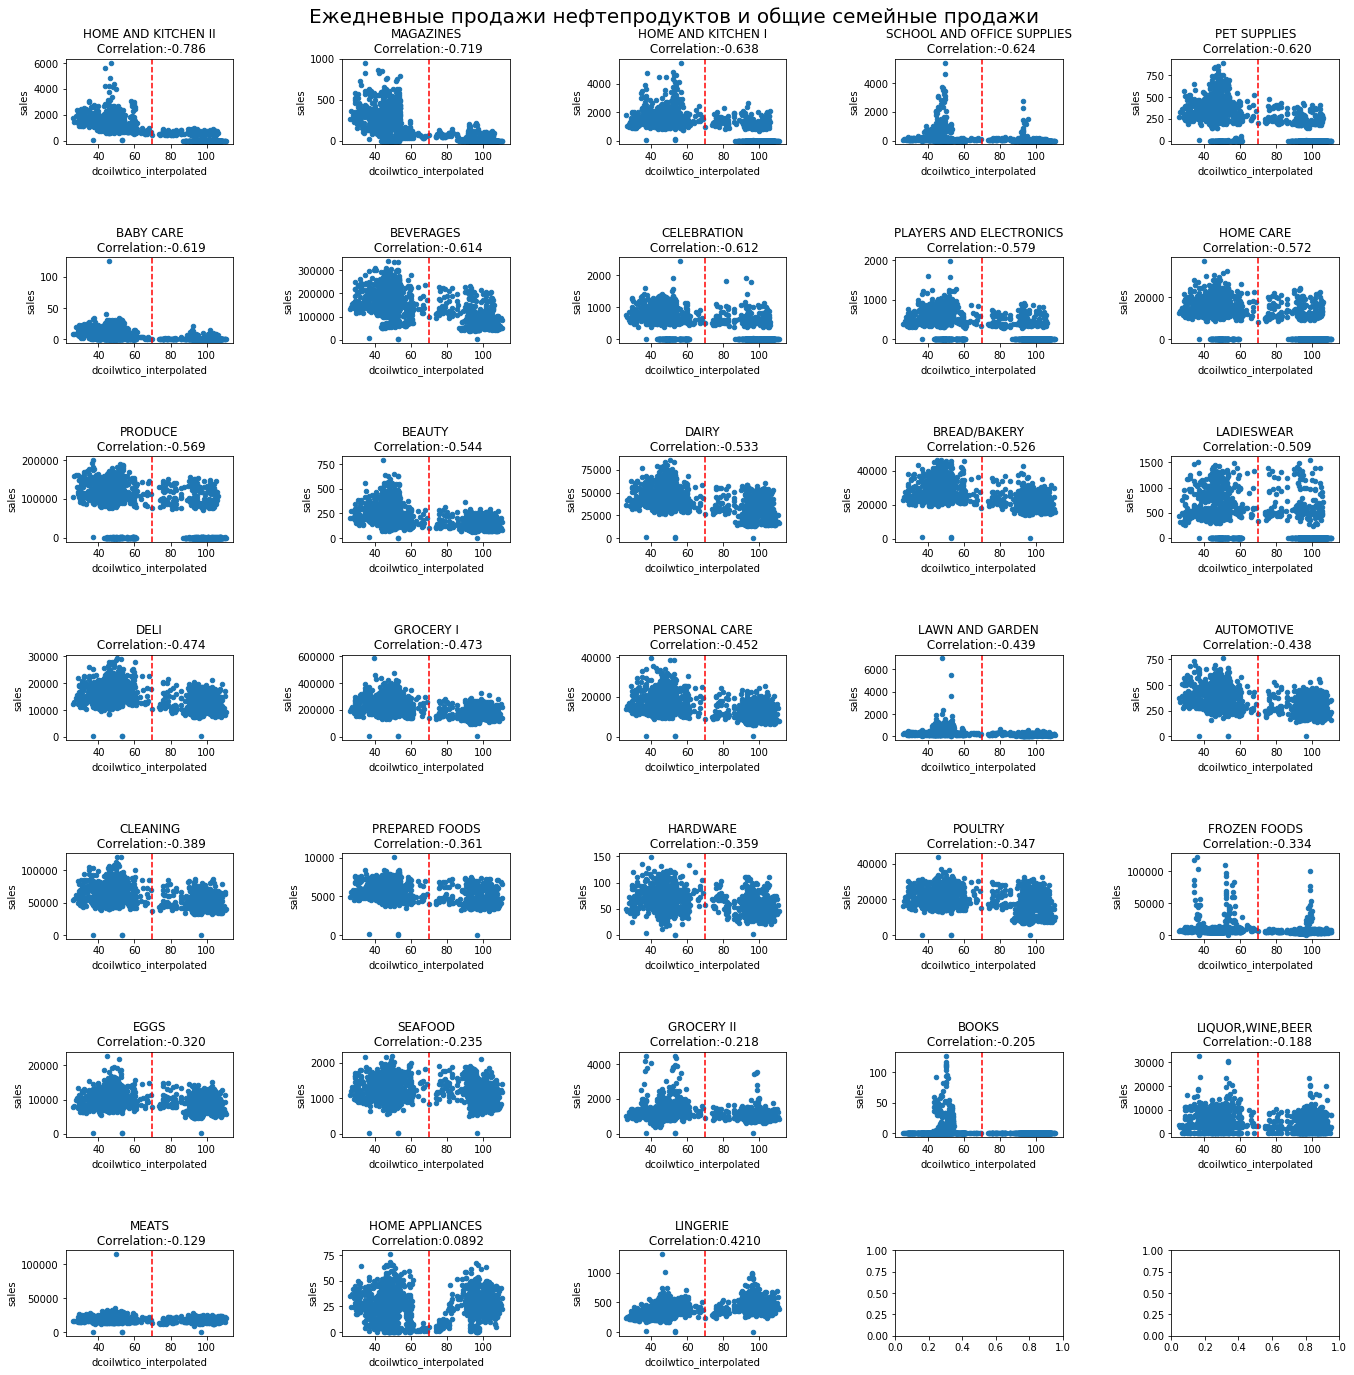

In [ ]:
import matplotlib.pyplot as plt

def plot_sales_and_oil_dependency():
    a = pd.merge(train.groupby(["date", "family"]).sales.sum().reset_index(),
                 oil.drop("dcoilwtico", axis=1), how="left")
    c = a.groupby("family").corr("spearman").reset_index()
    c = c[c.level_1 == "dcoilwtico_interpolated"][["family", "sales"]].sort_values("sales")
    
    fig, axes = plt.subplots(7, 5, figsize=(20, 20))
    for i, fam in enumerate(c.family):
        a[a.family == fam].plot.scatter(x="dcoilwtico_interpolated", y="sales", ax=axes[i // 5, i % 5])
        axes[i // 5, i % 5].set_title(fam + "\n Correlation:" + str(c[c.family == fam].sales.iloc[0])[:6],
                                 fontsize=12)
        axes[i // 5, i % 5].axvline(x=70, color='r', linestyle='--')

    plt.tight_layout(pad=5)
    plt.suptitle("Ежедневные продажи нефтепродуктов и общие семейные продажи \n", fontsize=20)
    plt.show()

plot_sales_and_oil_dependency()

In [ ]:
oil_rdy['rolling_mean_7'] = oil_rdy['dcoilwtico_interpolated'].rolling(7).mean()
oil_rdy.fillna(93.1, inplace=True)
oil_rdy

,dcoilwtico_interpolated,rolling_mean_7
date,,
2013-01-01,93.100000,93.100000
2013-01-02,93.140000,93.100000
2013-01-03,92.970000,93.100000
2013-01-04,93.120000,93.100000
2013-01-05,93.146667,93.100000
...,...,...
2017-08-27,46.816667,47.490000
2017-08-28,46.400000,47.348571
2017-08-29,46.460000,47.178571


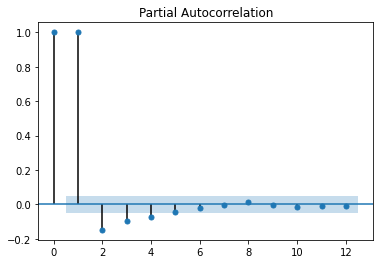

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

_ = plot_pacf(oil_rdy.rolling_mean_7, lags=12, method='ywm')  # 1 lag

In [ ]:
for i in range(1, 2) :
    oil_rdy[f'oil_lag_{i}'] = oil_rdy.rolling_mean_7.shift(i)
oil_rdy.fillna(93.1, inplace=True)

In [ ]:
stores = pd.read_csv(PATH + 'stores.csv', index_col='store_nbr',
                     converters={'city': strip_spaces, 'state': strip_spaces})  # убираем пробелы

stores.head()

,city,state,type,cluster
store_nbr,,,,
1,Quito,Pichincha,D,13
2,Quito,Pichincha,D,13
3,Quito,Pichincha,D,8
4,Quito,Pichincha,D,9
5,SantoDomingo,SantoDomingodelosTsachilas,D,4


In [ ]:
# Посмотрим на уникальные значения
print('Cities:\n', stores['city'].unique())  
print('States:\n', stores['state'].unique())  
print('Store types:\n', stores['type'].unique())  # не было представлено информации 
print('Clusters:\n', sorted(list(stores['cluster'].unique())))


# Пропущенные значения
print('Missing values:', stores.isna().sum().sum())

Cities:
 ['Quito' 'SantoDomingo' 'Cayambe' 'Latacunga' 'Riobamba' 'Ibarra'
 'Guaranda' 'Puyo' 'Ambato' 'Guayaquil' 'Salinas' 'Daule' 'Babahoyo'
 'Quevedo' 'Playas' 'Libertad' 'Cuenca' 'Loja' 'Machala' 'Esmeraldas'
 'Manta' 'ElCarmen']
States:
 ['Pichincha' 'SantoDomingodelosTsachilas' 'Cotopaxi' 'Chimborazo'
 'Imbabura' 'Bolivar' 'Pastaza' 'Tungurahua' 'Guayas' 'SantaElena'
 'LosRios' 'Azuay' 'Loja' 'ElOro' 'Esmeraldas' 'Manabi']
Store types:
 ['D' 'B' 'C' 'E' 'A']
Clusters:
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
Missing values: 0


In [ ]:
stores_rdy = stores.loc[:, ['city', 'state']]
stores_rdy.head()

,city,state
store_nbr,,
1,Quito,Pichincha
2,Quito,Pichincha
3,Quito,Pichincha
4,Quito,Pichincha
5,SantoDomingo,SantoDomingodelosTsachilas


# **2. МОДЕЛИРОВАНИЕ**

In [ ]:
!pip install fbprophet

In [ ]:
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly

In [ ]:
m = Prophet()
m.fit(df)

NameError: ignored